## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('((group == "control") & (landing_page == "new_page")) | ((group == "treatment") & (landing_page == "old_page"))').shape

(3893, 5)

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query('((group == "control") & (landing_page == "old_page")) | ((group == "treatment") & (landing_page == "new_page"))')

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[(df2.user_id.duplicated())]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates('user_id',inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
df2[df2.group == 'control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
df2[df2.group == 'treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
len(df2[df2.landing_page == 'new_page'])/len(df2)

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**>> The ratio of new_page to old_page (treatment to control) is almost 50%. Thus, comparing the mean conversion rates of both pages would seem fair. From the obtained means, the old_page had a higher conversion than the new_page; however, with a small margin. Further statistical studies can confirm or reject this conclusion.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{o}$** : **$p_{new} - p_{old} <= 0$**

**$H_{1}$** : **$p_{new} - p_{old} > 0$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_new = df.converted.mean()
p_new

0.11965919355605512

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
p_old = p_new

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = len(df2.query('group == "treatment"'))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = len(df2.query('group == "control"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.choice([0,1],size=n_new,p=[1-p_new,p_new])
new_page_converted.mean()

0.11911774826233569

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0,1],size=n_old,p=[1-p_old,p_old])
old_page_converted.mean()

0.11881685642303509

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
diff_converted = new_page_converted.mean()-old_page_converted.mean()
diff_converted

0.00030089183930059882

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([0,1],size=n_new,p=[1-p_new,p_new])
    old_page_converted = np.random.choice([0,1],size=n_old,p=[1-p_old,p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

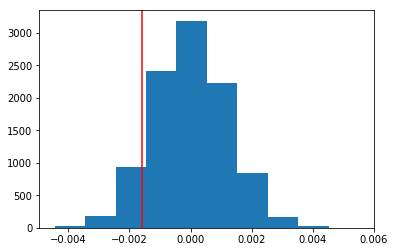

In [26]:
plt.hist(p_diffs)
p_conv_old = df2[df2.landing_page == 'old_page'].converted.mean()
p_conv_new = df2[df2.landing_page == 'new_page'].converted.mean()
p_conv_diff = p_conv_new-p_conv_old
plt.axvline(x=p_conv_diff,color='r')

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
null_vals = np.random.normal(0,p_diffs.std(),10000)
p_value = (null_vals > p_conv_diff ).mean()
p_value

0.90559999999999996

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The obtained p_value (90.5%) is higher than the suggested type_I error rate of 5%. Thus, we fail to reject the null hypothesis in favor of the alternative hypothesis. Meaning that the new page is not as good or worse than the old page in terms of the conversion rate.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = len(df2.query('(landing_page =="old_page") & (converted == 1)'))
convert_new = len(df2.query('(landing_page =="new_page") & (converted == 1)'))
n_old = len(df2.query('(landing_page =="old_page")'))
n_new = len(df2.query('(landing_page =="new_page")'))
print(convert_old,convert_new,n_old,n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [29]:
count = np.array([convert_new, convert_old])
nobs = np.array([n_new, n_old])
stat, pval = sm.stats.proportions_ztest(count, nobs,value=0,alternative='larger')
print('statistic: {0:0.3f}'.format(stat))
print('p_value: {0:0.3f}'.format(pval))


statistic: -1.311
p_value: 0.905


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Using the z-test, we fail to reject the null hypothesis giving a p_value of 90.5% larger than the type I error (Almost same as using sampling distribution). The z-score explains how many standard deviations away is the difference in means between the sample and the population.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**This is a binary classification problem (logistic regression).**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df3 = df2.copy()
df3['intercept'] = 1
df3[['ab_page','old']] = pd.get_dummies(df3.landing_page)
df3.drop(columns=['landing_page','old'],inplace=True)
df3.head()

,user_id,timestamp,group,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [31]:
import statsmodels.api as sm
mod = sm.Logit(df3.converted,df3[['intercept','ab_page']])
res = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 Nov 2019   Pseudo R-squ.:               8.077e-06
Time:                        05:10:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The statsmodel logistic regression model uses a "Two-sided" (equality) hypthesis. Thus, the obtained p-value (0.19) is twice that obtained from the z-test ((1-0.905)*2). Again, we fail to reject the null hypthesis. By noticing the ab_page coefficient, we can see that introducing the new_page results in a decrease of the conversion rate by a factor of 0.985 (e^(-0.015)).**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**By introducing more explanatory variables into the regression model, it becomes possible to explain more of the variablity in the response variable (higher R_squared value). However, it might become a problem if a Multicollinearity exist between these variables. In this case, negative coefficients problem arises and wrong interpretations would be encountered.**

**Introducing higher order terms of existing variables might also help build better models but the coefficients cannot be explained as clearly as in the fisrt order regression.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [33]:
df_countries = pd.read_csv('countries.csv')
df4 = df2.join(df_countries.set_index('user_id'),on='user_id')
df4.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,US


In [34]:
df4.groupby(['country']).converted.mean()

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

In [35]:
df4[['CA','UK','US']] = pd.get_dummies(df4.country)
df4.drop(columns=['country','CA'],inplace=True)
df4.head()

,user_id,timestamp,group,landing_page,converted,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


In [36]:
df4['intercept'] = 1
mod = sm.Logit(df4.converted,df4[['intercept','UK','US']])
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 06 Nov 2019   Pseudo R-squ.:               1.521e-05
Time:                        05:10:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [37]:
np.exp(res.params)

intercept    0.130350
UK           1.052027
US           1.041647
dtype: float64

**Based on the logistic regression result with respect to the countries, we can see that the UK conversion is higher by a factor of 1.05 compared to CA. Similiarly, the US is higher by a factor of 1.042 compared to CA. The p_value for the UK is lower than the US which makes us more inclined to reject the null hypothesis for the UK than the US.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [38]:
df5 = df2.join(df_countries.set_index('user_id'),on='user_id')
df5[['ab_page','old']] = pd.get_dummies(df5.landing_page)
df5[['CA','UK','US']] = pd.get_dummies(df5.country)
df5.drop(columns=['landing_page','old','country','CA'],inplace=True)
df5['new_page_US']=df5['US']*df5['ab_page']
df5['new_page_UK']=df5['UK']*df5['ab_page']
df5['intercept'] = 1
df5.head()

,user_id,timestamp,group,converted,ab_page,UK,US,new_page_US,new_page_UK,intercept
0,851104,2017-01-21 22:11:48.556739,control,0,0,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,0,0,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,0,1,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,0,1,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,1,0,0,1,0,0,1


In [39]:
mod = sm.Logit(df5.converted,df5[['intercept','UK','US','ab_page','new_page_US','new_page_UK']])
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 Nov 2019   Pseudo R-squ.:               3.482e-05
Time:                        05:10:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
UK              0.0118      0.040      0.296      0.767      -0.066       0.090
US              0.0175      0.038      0.465      0.642      -0.056       0.091
ab_page        -0.0674      0.052     -1.297      0.195      -0.169       0.034
new_page_US     0.0469      0.054      0.872      0.383      -0.059       0.152
new_page_UK     0.0783      0.057      1.378      0.168      -0.033       0.190
===============================================================================
"""

In [40]:
np.exp(res.params)

intercept      0.134794
UK             1.011854
US             1.017682
ab_page        0.934776
new_page_US    1.048001
new_page_UK    1.081428
dtype: float64

**We can see a difference between the interaction effect on the new_page on US users (1.04) and on the UK users (1.08). The first order coefficient of both US and UK is almost the same (1.01-1.018). However, the interaction between different terms makes hard to conclude the effect of the new_page.**

In [41]:
df_countries.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

**The noticed difference between contries might be due to the number of users not the actual effect of the new_page.**

### >>Time effect on Conversion
We shall inspect the effect of time on the conversion. But, first let's sort by timestamp.

In [42]:
df6 = df2.sort_values(by=['timestamp'])
df6.head()

,user_id,timestamp,group,landing_page,converted
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0


In [43]:
df6.timestamp.min(),df6.timestamp.max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

**The A/B test was conducted for 23 days (less than a month). Let's extact the date information (day, hour) and inspect futher.**

In [44]:
df6['date'] = pd.to_datetime(df['timestamp'])
df6['day'] = pd.DatetimeIndex(df6['date']).day
df6['hour'] = pd.DatetimeIndex(df6['date']).hour
df6['weekday'] = pd.DatetimeIndex(df6['date']).weekday                         #Get the day of the week
df6.head()

,user_id,timestamp,group,landing_page,converted,date,day,hour,weekday
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0,2017-01-02 13:42:05.378582,2,13,0
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0,2017-01-02 13:42:15.234051,2,13,0
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0,2017-01-02 13:42:21.786186,2,13,0
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0,2017-01-02 13:42:26.640581,2,13,0
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0,2017-01-02 13:42:27.851110,2,13,0


In [45]:
df6['day'].value_counts()

8     13387
11    13361
6     13353
10    13350
23    13349
21    13309
22    13265
15    13263
9     13243
20    13213
7     13213
3     13208
12    13159
17    13155
14    13147
16    13136
19    13130
4     13119
18    13085
13    13060
5     12932
24     7435
2      5712
Name: day, dtype: int64

**The number of users is significantly lower on the first and last day which might affect the conversion rate on these days.**

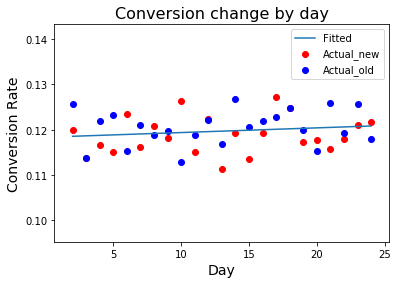

In [46]:
conversion_mean_day = df6.groupby(['day']).converted.mean()
conversion_mean_day_new = df6.query('landing_page == "new_page"').groupby(['day']).converted.mean()
conversion_mean_day_old = df6.query('landing_page == "old_page"').groupby(['day']).converted.mean()
unique_days = df6['day'].unique()
plt.scatter(unique_days,conversion_mean_day_new,color = 'r',label='Actual_new')
plt.scatter(unique_days,conversion_mean_day_old,color = 'b',label='Actual_old')

plt.xlabel('Day',fontsize=14);
plt.ylabel('Conversion Rate',fontsize=14);
plt.title('Conversion change by day',fontsize=16);
plt.plot(unique_days, np.poly1d(np.polyfit(unique_days, conversion_mean_day, 1))(unique_days),label='Fitted');
plt.legend();

**Although the conversion rate is fluctuating as time goes, we can see an overall increase in the conversion rate. Such fluctuations make it hard to see the effect of time, so regression might help see trends more clearly.**

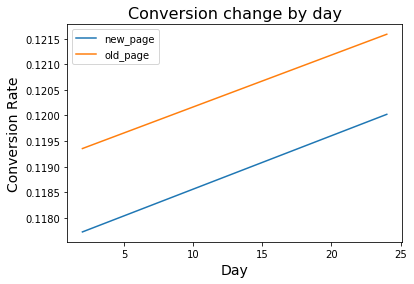

In [47]:
plt.plot(unique_days, np.poly1d(np.polyfit(unique_days, conversion_mean_day_new, 1))(unique_days),label='new_page'); 
plt.plot(unique_days, np.poly1d(np.polyfit(unique_days, conversion_mean_day_old, 1))(unique_days),label='old_page'); 
plt.xlabel('Day',fontsize=14);
plt.ylabel('Conversion Rate',fontsize=14);
plt.title('Conversion change by day',fontsize=16);
plt.legend();

**By comparing the new and old pages, we can see the conversion increasing for both at nearly the same rate. However, the old_page has a higher conversion at all days.**

**Similiar analysis can be conducted to view the effect of "hour".**


Use logistic regression to further investigate the effect of time. We need to get dummy variables for daytime and days. 

In [48]:
df6['isdaytime'] = ((df6.hour >= 0) & (df6.hour < 12))                         #Check if it is a daytime
df6['first_days'] = ((df6.day >= 2) & (df6.day < 13))                          #Check if it is in the ealy test days
df6['isweekday'] = ((df6['weekday']%7 == 5) | (df6['weekday']%7 == 6))         #Check if it is a weekday
df6[['weekend','weekday']] = pd.get_dummies(df6.isweekday)
df6.drop(columns=['isweekday','weekend','date'],inplace=True)
df6[['pm','am']] = pd.get_dummies(df6.isdaytime)
df6[['later_days','early_days']] = pd.get_dummies(df6.first_days)
df6.drop(columns=['isdaytime','pm','later_days','first_days'],inplace=True)
df6.head()

,user_id,timestamp,group,landing_page,converted,day,hour,weekday,am,early_days
131228,922696,2017-01-02 13:42:05.378582,treatment,new_page,0,2,13,0,0,1
184884,781507,2017-01-02 13:42:15.234051,control,old_page,0,2,13,0,0,1
83878,737319,2017-01-02 13:42:21.786186,control,old_page,0,2,13,0,0,1
102717,818377,2017-01-02 13:42:26.640581,treatment,new_page,0,2,13,0,0,1
158789,725857,2017-01-02 13:42:27.851110,treatment,new_page,0,2,13,0,0,1


In [49]:
df6['intercept'] = 1
mod = sm.Logit(df6.converted,df6[['intercept','am','early_days','weekday']])
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 06 Nov 2019   Pseudo R-squ.:               2.596e-05
Time:                        05:10:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1373
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9775      0.011   -182.578      0.000      -1.999      -1.956
am            -0.0240      0.011     -2.098      0.036      -0.046      -0.002
early_days    -0.0132      0.012     -1.137      0.255      -0.036       0.010
weekday       -0.0020      0.013     -0.152      0.879      -0.027       0.024
==============================================================================
"""

In [50]:
np.exp(res.params)

intercept     0.138415
am            0.976283
early_days    0.986855
weekday       0.998018
dtype: float64

**1. Hour of the day: the daytime has a lower conversion (0.976) than night time. Higher activity is expected on night. The low p_value gives high confidence in this conclusion.**

**2. Day progress: early days have a lower conversion rate (0.987); meaning the conversion rate is increasing with time.**

**3. Weekday/Weekends: The conversion drops on weekday by a rate of 0.998; giving an advantage to weekends.**


<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0